In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
## Imports
import zipfile
import os
import sys
import random

import matplotlib
from sklearn.manifold import TSNE
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.image as mpimg
import glob
from os import listdir
from os.path import isfile, join
from sklearn.metrics import roc_curve, auc,roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV
from itertools import cycle
import seaborn as sns
import statistics as st
import math
import datetime
from matplotlib.ticker import MaxNLocator
import keras.backend as K
import plotly.express as px 

## Seeding 
seed = 42
#random.seed = seed
np.random.seed = seed
tf.seed = seed

# U-NET SEGMENTATION

# Text

Arxiv Link to original paper: <a href="https://arxiv.org/abs/1505.04597">U-Net: Convolutional Networks for Biomedical Image Segmentation</a>


## U-Net is a fully convolutional network (FCN) for semantic segmentation.
*   An FCN is a network using only convolutional layers i.e no dense or recurrent.
*   Semantic Segmentation means that it performs classification on a pixel level, each individual pixel is assigned a certain class. E.g background pixel, LFE pixel 😸. We refer to it as **dense prediction**.




## 1.1 Architecture

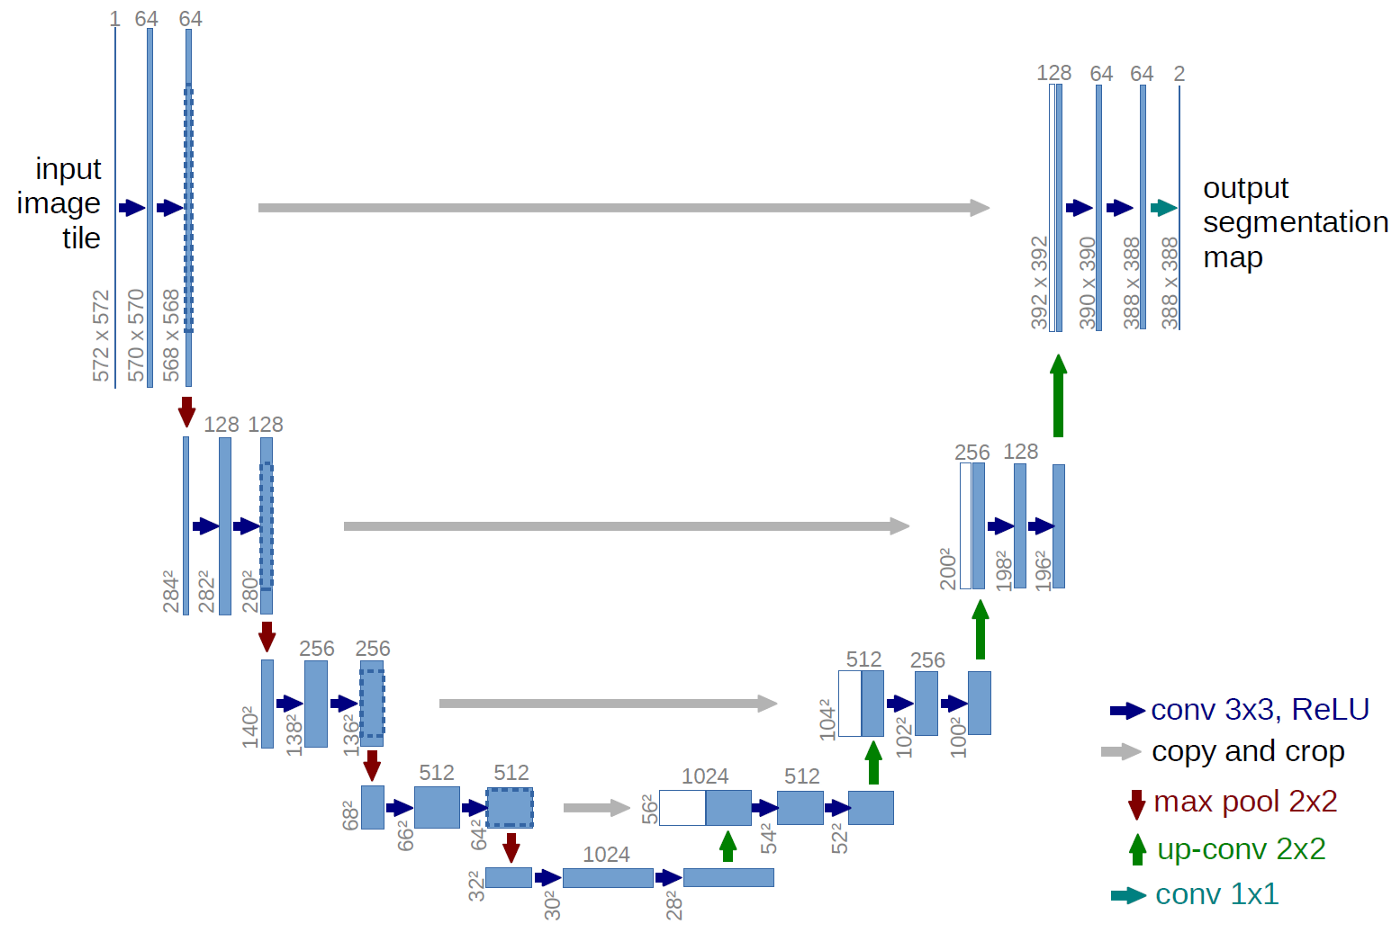

In [ ]:
from IPython.display import Image
display(Image('/content/drive/MyDrive/unet_architecture.png', width=700, height=400))


<h3>UNet Architecture is a U shaped network with 3 parts:</h3>
<ol>
    <li>The Contracting/Downsampling Path</li>
    <li>Bottleneck</li>
    <li>The Expanding/Upsampling Path</li>
</ol>

<h3>Downsampling Path: </h3> 
<ol>
    <li>It consists of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling.</li> 
    <li>At each downsampling step we double the number of feature channels.
    <li> In total there are 4 blocks of two 3x3 convolutions. The convolutional blocks have an ascending number of filters of 16, 32, 64 and 128. So we double the number of filters and thus feature channels with each block.
</ol>
<h3>Bottleneck: </h3> 
<li> The bottleneck consists of two 3x3 convolutional layers each with 256 filters.
<h3>Upsampling Path: </h3> 
<ol>
     <li> Every  step  in  the  expansive  path  consists  of  an  upsampling  of  the feature map followed by a 2x2 convolution (“up-convolution”), a concatenation with the correspondingly feature  map  from  the  downsampling  path,  and  two  3x3  convolutions,  each  followed by a ReLU.</li>
     <li>The upsampling layer repeats the rows and columns of the data by a given amount, we repeat each row x2 and column x2.
     <li> Each step in the expansive path has a corresponding feature map in the downsampling path, i.e the step with the same number of filters. So the first step in the downsampling path corresponds to the last step in the upsampling path and so on.
</ol>

<h3> Skip Connection: </h3>
The skip connection from the downsampling path are concatenated with feature map during upsampling path. These skip connection provide local information to global information while upsampling.

<h3> Final Layer: </h3>
At the final layer a 1x1 convolution is used to map each feature vector to the desired number of classes. There is just one filter, so the output is a single feature map with pixel classifications. In this case, it is binary. The pixels are classified as 0 or 1, background or LFE.

## 1.2 Advantages
<h3> Advantages: </h3>
<ol>
    <li>The UNet combines the location information from the downsampling path to finally obtain a general information combining localisation and context, which is necessary to predict a good segmentation map.</li>
    <li>No Dense layer is used, so image sizes can be used.</li>
</ol>

## Model Metrics

#### **Final Layer Activation Function**

**Sigmoid**

The sigmoid activation function is s-shaped and outputs a number between 0 and 1. The sigmoid function is known as a squashing function because for values >|10|, the output approaches 0 (-) or 1(1).

$\sigma(t) = \frac{1}{1+e^{-t}}$

The sigmoid activation function is used for non-linearly separable problems, it is monotonically increasing, continuous within its domain and differentiable everywhere. This makes it easy to derive the equations needed for back propagation.

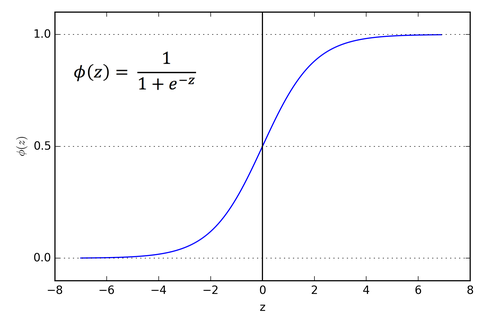

In [ ]:
display(Image('/content/drive/MyDrive/1_Xu7B5y9gp0iL5ooBj7LtWw.png', width=500, height=400))

#### **Loss Function**
#####**Binary Crossentropy**


Binary Cross Entropy is the negative average of the log of corrected predicted probabilities. Corrected probabilities are the models prediction that the input belongs to its actual class. It is calculated using the actual value (0/1 for binary classification) and the predicted value (between 0 and 1 for sigmoid activation).

Binary Cross Entropy for Binary Classification may be calculated using the formula:

$\frac{-1}{N}\sum_{i=1}^{N}log(p_i)$ 

where N is the total number of inputs and p$_i$ is the predicted probability of each input. 

### **Accuracy Metrics**

**Pixel Accuracy**

The standard accuracy metric used in keras computes the number of accurately predicted inputs/total inputs.

So per image, accuracy = correctly predicted pixels/ total pixels.

The trouble is that for images without an LFE in particular, as the measure will be biased in mainly reporting how well you identify negative cases.

**Intersection-Over-Union (IoU)**

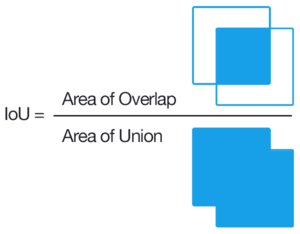

In [ ]:
display(Image('/content/drive/MyDrive/0_kraYHnYpoJOhaMzq.png', width=300, height=200))

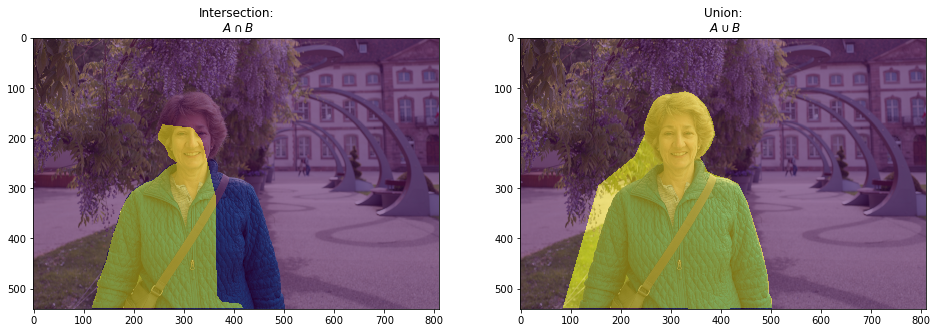

In [ ]:
display(Image('/content/drive/MyDrive/intersection_union.png', width=700, height=300))

**F1 Score/Dice Coefficient**

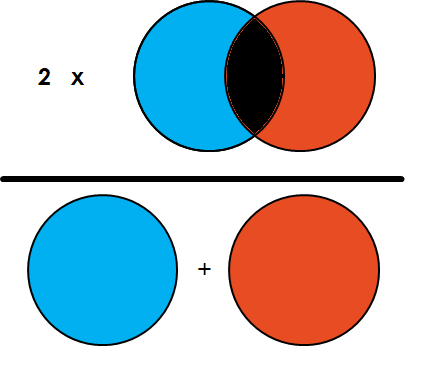

In [ ]:
display(Image('/content/drive/MyDrive/1_yUd5ckecHjWZf6hGrdlwzA.png', width=400, height=300))

# 1.4 Code

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/Elizabeth_PhD_Folder/lfe_images/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/Elizabeth_PhD_Folder/lfe_images/test.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

##Plotting Accuracy

In [ ]:
# Define some useful functions
class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []

        self.iou = []
        self.val_iou = []

        self.dice = []
        self.val_dice = []

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        self.iou.append(logs.get('IoU'))
        self.val_iou.append(logs.get('val_IoU'))

        self.dice.append(logs.get('f1_metric'))
        self.val_dice.append(logs.get('val_f1_metric'))
        # print(self.acc)
        # print(self.val_acc)
        # print(logs)
        
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(32, 6))
       
        #plt.plot([1, 4])
        plt.subplot(131) 
        plt.tick_params(axis='both', which='major', labelsize=18)
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss',fontsize=25)
        plt.xlabel('epoch',fontsize=25)
        plt.title('Model Loss',fontsize=28)
        plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
        plt.legend(fontsize=18)

        plt.subplot(132) 
        plt.tick_params(axis='both', which='major', labelsize=18)        
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend(fontsize=18)
        plt.ylabel('accuracy',fontsize=25)
        plt.xlabel('epoch',fontsize=25)
        plt.title('Model Accuracy',fontsize=28)
        plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))


        plt.subplot(133)   
        plt.tick_params(axis='both', which='major', labelsize=18)      
        plt.plot(self.x, self.iou, label="training accuracy")
        plt.plot(self.x, self.val_iou, label="validation accuracy")
        plt.legend(fontsize=18)
        plt.ylabel('IoU',fontsize=25)
        plt.xlabel('epoch',fontsize=25)
        plt.title('IoU',fontsize=28)
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();     

'''
        plt.subplot(144)         
        plt.plot(self.x, self.dice, label="training accuracy")
        plt.plot(self.x, self.val_dice, label="validation accuracy")
        plt.legend()
        plt.ylabel('Dice-Score')
        plt.xlabel('epoch')
        plt.title('Dice-Score')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        '''
       
        


'\n        plt.subplot(144)         \n        plt.plot(self.x, self.dice, label="training accuracy")\n        plt.plot(self.x, self.val_dice, label="validation accuracy")\n        plt.legend()\n        plt.ylabel(\'Dice-Score\')\n        plt.xlabel(\'epoch\')\n        plt.title(\'Dice-Score\')\n        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))\n        '

## Data Generator

In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size, image_w, image_h):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_w = image_w
        self.image_h =image_h
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".npy"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)
        
        ## Reading Image
        image = np.load(image_path, allow_pickle=True)
        resize = tf.keras.Sequential([layers.Resizing(self.image_h, self.image_w)])
        image = resize(image)
        
        
        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = np.load(_mask_path,allow_pickle=True)
            _mask_image=np.reshape(_mask_image,(_mask_image.shape[0],_mask_image.shape[1],1))
            resize = tf.keras.Sequential([layers.Resizing(self.image_h, self.image_w)])
            mask = resize(_mask_image)[:,:,0]
            mask=np.where(mask>0, 1, 0).reshape(self.image_h,self.image_w,1)

            
         
            
        #Label
        label_path = os.path.join(self.path, id_name, "label", id_name) + ".npy"
        label = np.load(label_path, allow_pickle=True)

        #Trajectory
        traj_path = os.path.join(self.path, id_name, "traj", id_name) + ".npy"
        traj = np.load(traj_path, allow_pickle=True)
        lat_s, lat_m, lt_s, lt_m = traj[0], traj[1], traj[2], traj[3]
        lat_s_arr=np.full((self.image_h, self.image_w, 1),lat_s)
        lat_m_arr=np.full((self.image_h, self.image_w, 1),lat_m)
        lt_s_arr =np.full((self.image_h, self.image_w, 1),lt_s)
        lt_m_arr=np.full((self.image_h, self.image_w, 1),lt_m)

        #Join
        im_all_channels = np.concatenate([image, lat_s_arr, lat_m_arr,lt_s_arr, lt_m_arr], axis=2)

        return im_all_channels, mask

    def horizontal(self, total_array, mask_array):
        #img
        im = tf.image.flip_left_right(total_array)
        im = np.reshape(im, (1, self.image_h,self.image_w, 6))
        #mask
        mask = tf.image.flip_left_right(mask_array)
        mask = np.reshape(mask, (1, self.image_h,self.image_w, 1))
        return im, mask



    def translate_right(self, total_array, mask_array):
        pad_left=100
        pad_right=0
        pad_top=0
        pad_bottom=0
        x=total_array[:,:,0:2]
        shape = [self.image_h, self.image_w, 2]
        # We use two functions to get our desired augmentation
        x = tf.image.pad_to_bounding_box(x, pad_top, pad_left, self.image_h + pad_bottom + pad_top, self.image_w + pad_right + pad_left)
        im = tf.image.crop_to_bounding_box(x, pad_bottom, pad_right, self.image_h, self.image_w)
        im = tf.concat([im, total_array[:,:,2:]], axis=2)
        im = np.reshape(im, (1, self.image_h,self.image_w, 6))


        shape = [self.image_h, self.image_w, 1]
        # We use two functions to get our desired augmentation
        mask = tf.image.pad_to_bounding_box(mask_array, pad_top, pad_left, self.image_h + pad_bottom + pad_top, self.image_w + pad_right + pad_left)
        mask = tf.image.crop_to_bounding_box(mask, pad_bottom, pad_right, self.image_h, self.image_w)
        mask = np.reshape(mask, (1, self.image_h,self.image_w, 3))

        return im, mask

    def gaussian_noise(self, total_array, mask_array):
        flux=total_array[:,:,0:1]
        pol=total_array[:,:,1:2]
        noise = tf.random.normal(shape=tf.shape(flux), mean=0.0, stddev=0.25,dtype=tf.float32)
        flux=flux+noise
        flux=np.clip(flux, 0, 1)
        pol=pol+noise
        pol=np.clip(pol, 0, 1)
        
        im = tf.concat([flux, pol,total_array[:,:,2:]], axis=2)
        im = np.reshape(im, (1, self.image_h,self.image_w, 6))
        mask_array = np.reshape(mask_array, (1, self.image_h,self.image_w, 1))
      
        return im, mask_array

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        im=[]
        mask=[]

        for id_name in files_batch:
            _im_all_channels, _mask = self.__load__(id_name)
            im.append(_im_all_channels)
            mask.append(_mask)
        
        im=np.array(im)
        mask=np.array(mask)
        
        ##Add augmentation
        inds=list(np.arange(len(self.ids)))
        inds_augment = random.choices(inds, k=3)


        #Horizontal Flip
        #h_ind = inds_augment[0]
        #h_im, h_mask = self.__load__(self.ids[h_ind])
        #h_flipped = self.horizontal(h_im, h_mask)
        
        

        #Gaussian Noise
        #g_ind = inds_augment[2]
        #g_im, g_mask = self.__load__(self.ids[g_ind])
        #gaussian_noise = self.gaussian_noise(g_im, g_mask)
        

        #im = np.concatenate([im],axis=0)
        #mask=np.concatenate([mask,gaussian_noise[1]],axis=0)
        
        
        return im, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [ ]:
class ValidGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size, image_w, image_h):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_w = image_w
        self.image_h =image_h
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".npy"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)

        ## Reading Image
        image = np.load(image_path, allow_pickle=True)
        resize = tf.keras.Sequential([layers.Resizing(self.image_h, self.image_w)])
        image = resize(image)

        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = np.load(_mask_path,allow_pickle=True)
            _mask_image=np.reshape(_mask_image,(_mask_image.shape[0],_mask_image.shape[1],1))
            resize = tf.keras.Sequential([layers.Resizing(self.image_h, self.image_w)])
            mask = resize(_mask_image)[:,:,0]
            mask=np.where(mask>0, 1, 0).reshape(self.image_h,self.image_w,1)

        #Label
        label_path = os.path.join(self.path, id_name, "label", id_name) + ".npy"
        label = np.load(label_path, allow_pickle=True)

        #trajectory
        traj_path = os.path.join(self.path, id_name, "traj", id_name) + ".npy"
        traj = np.load(traj_path, allow_pickle=True)
        lat_s, lat_m, lt_s, lt_m = traj[0], traj[1], traj[2], traj[3]
        lat_s_arr=np.full((self.image_h, self.image_w, 1),lat_s)
        lat_m_arr=np.full((self.image_h, self.image_w, 1),lat_m)
        lt_s_arr =np.full((self.image_h, self.image_w, 1),lt_s)
        lt_m_arr=np.full((self.image_h, self.image_w, 1),lt_m)

        im_all_channels = np.concatenate([image, lat_s_arr, lat_m_arr,lt_s_arr, lt_m_arr], axis=2)

        return im_all_channels, mask


    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        im=[]
        mask=[]
        
        for id_name in files_batch:
            _im_all_channels, _mask = self.__load__(id_name)
            im.append(_im_all_channels)
            mask.append(_mask)
        
        im=np.array(im)
        mask=np.array(mask)
        return im, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

## UNet Model

## Different Convolutional Blocks

In [ ]:
train_path = "/content/train/"
epochs = 60
batch_size = 16
f = [64,128, 256, 512,1024]


## Training Ids
random_ids = next(os.walk(train_path))[1]

count=3000
ids=[str(i).zfill(3) for i in np.arange(count)]
total_ids = [i for i in ids if i in random_ids]




## Validation Data Size
#Train set is 75% of total, and validation is 1/3 of the train set and so it is 25% of total data
train_label=np.load('/content/drive/MyDrive/Elizabeth_PhD_Folder/lfe_images/train_label.npy',allow_pickle=True)
train_ids, valid_ids = train_test_split(total_ids, test_size=.35, random_state=42,stratify=train_label)

In [ ]:
def down_block(x, filters, do,kernel_size=(3, 3), padding='same', strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    dp1 = keras.layers.Dropout(do)(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(dp1)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)

    return c, p

def up_block(x, skip, filters, do,kernel_size=(3,3), padding='same', strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    dp1 = keras.layers.Dropout(do)(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(dp1)
    
    return c

def bottleneck(x, filters, do,kernel_size=(3,3), padding='same', strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    dp1 = keras.layers.Dropout(do)(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(dp1)
    return c

In [ ]:
def UNet(do):
    inputs = keras.layers.Input((image_h, image_w, channels))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0],do) 
    c2, p2 = down_block(p1, f[1],do) 
    c3, p3 = down_block(p2, f[2],do) 
    c4, p4 = down_block(p3, f[3],do) 
    #c5, p5 = down_block(p4, f[4],do)
    #c6, p6 = down_block(p5, f[5],do)
    #c7, p7 = down_block(p6, f[6],do)
    
    bn = bottleneck(p4, f[4],do)
    
    #u1 = up_block(bn, c7, f[6],do)
    #u2 = up_block(u1, c6, f[5],do) 
    #u3 = up_block(u2, c5, f[4],do) 
    u4 = up_block(bn, c4, f[3],do) 
    u5 = up_block(u4, c3, f[2],do) 
    u6 = up_block(u5, c2, f[1],do) 
    u7 = up_block(u6, c1, f[0],do) 
    
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u7)
    model = keras.models.Model(inputs, outputs)
    return model

## Hyperparameters

In [ ]:
def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    y_true=tf.cast(y_true, dtype=tf.float32)
    return 1 - dice_coef(y_true, y_pred)

In [ ]:
image_w = 128
image_h = 384
channels=6
do=0.4
model = UNet(do)
#optname = 'SGD'
optname='Adam'
lr =1e-4
opt=tf.keras.optimizers.Adam(learning_rate=lr,name=optname)
#opt = tf.keras.optimizers.SGD(learning_rate=lr, decay=1e-6, momentum=0.99, nesterov=True,name=optname)
#opt = tf.keras.optimizers.RMSprop(learning_rate=lr,rho=0.9, momentum=0.0, epsilon=1e-07,centered=False,name=optname)
binary_iou= tf.keras.metrics.BinaryIoU(name='IoU')

model.summary()
model.compile(optimizer=opt, loss='binary_crossentropy',
              metrics=['accuracy', binary_iou])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 384, 128, 6  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_29 (Conv2D)             (None, 384, 128, 64  3520        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_14 (Dropout)           (None, 384, 128, 64  0           ['conv2d_29[0][0]']              
                                )                                                           

### Load Pretrained Model

In [ ]:
root = '/content/drive/MyDrive/Elizabeth_PhD_Folder/Colab_Notebooks/Models/'
max_filter=f[-1]
model_label = 'UNET_'+str(optname) + 'LR' +str(lr)+'_6steps_minfilter'+str(f[0])+'maxfilter'+str(max_filter)+'_diceloss'
print(model_label)

UNET_AdamLR0.0001_6steps_minfilter64maxfilter1024_diceloss


## Training the model

In [ ]:
train_gen = DataGen(train_ids, train_path, image_h=image_h, image_w=image_w, batch_size=batch_size)
valid_gen = ValidGen(valid_ids, train_path, image_h=image_h, image_w=image_w, batch_size=batch_size)


train_steps = len(train_ids)//(batch_size)
valid_steps = len(valid_ids)//(batch_size)


pltCallBack = PlotLossAccuracy()

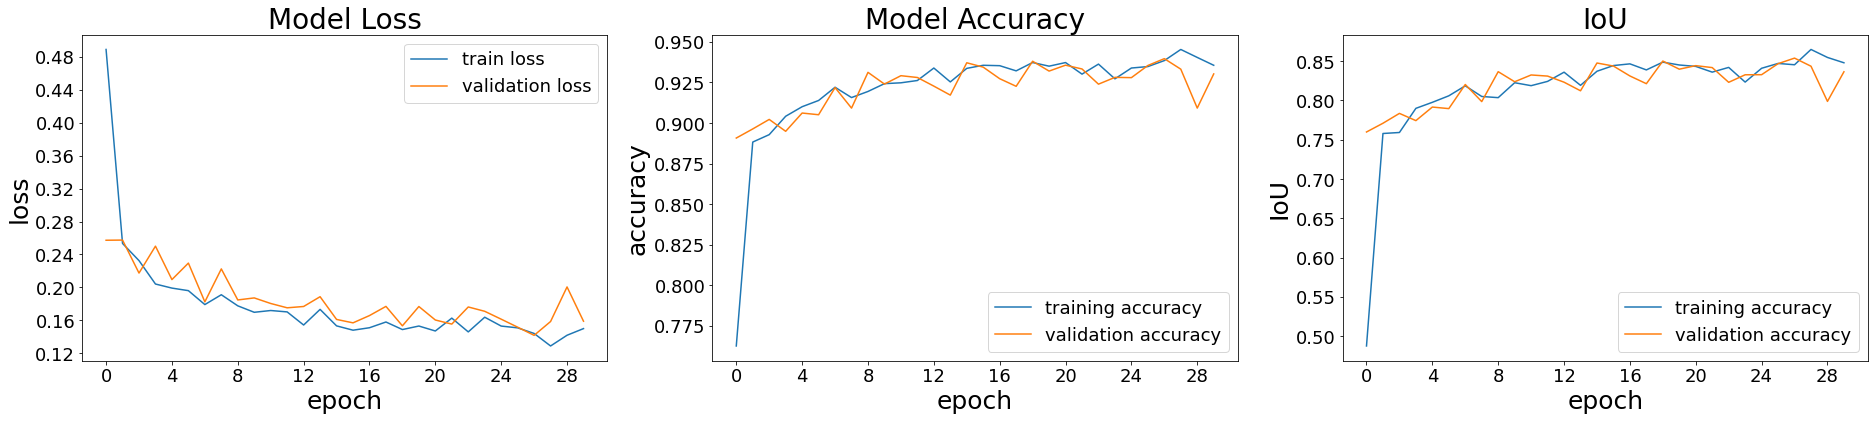

70/70 [==============================] - 48s 695ms/step - loss: 0.1500 - accuracy: 0.9356 - IoU: 0.8479 - val_loss: 0.1589 - val_accuracy: 0.9302 - val_IoU: 0.8364


KeyboardInterrupt: ignored

In [ ]:
root = '/content/drive/MyDrive/Elizabeth_PhD_Folder/Colab_Notebooks/Models/'
checkpoint_filepath = root+model_label
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=False,monitor='val_accuracy',mode='auto',save_best_only=False)
#Fit Model
epochs=60
history = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs,verbose=1, callbacks=[model_checkpoint_callback,pltCallBack])

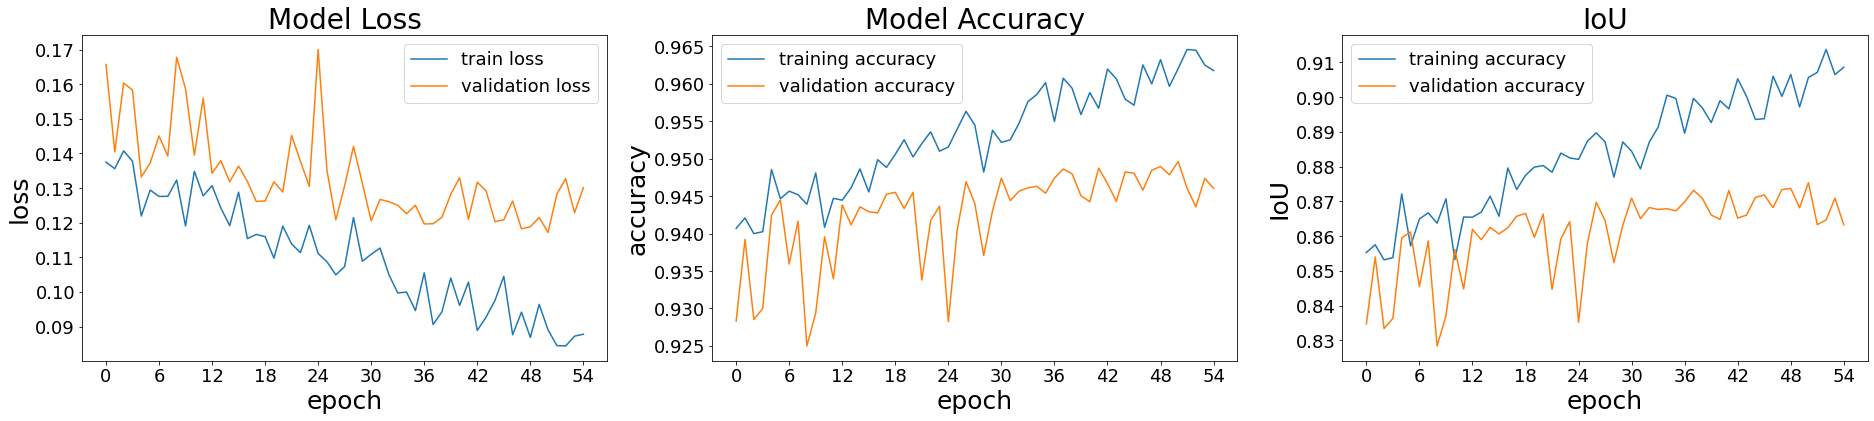

70/70 [==============================] - 47s 675ms/step - loss: 0.0878 - accuracy: 0.9618 - IoU: 0.9086 - val_loss: 0.1301 - val_accuracy: 0.9460 - val_IoU: 0.8632
Epoch 56/60
70/70 [==============================] - ETA: 0s - loss: 0.0951 - accuracy: 0.9598 - IoU: 0.8996

KeyboardInterrupt: ignored

In [ ]:
root = '/content/drive/MyDrive/Elizabeth_PhD_Folder/Colab_Notebooks/Models/'
checkpoint_filepath = root+model_label
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=False,monitor='val_accuracy',mode='auto',save_best_only=False)
#Fit Model
epochs=60
history = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs,verbose=1, callbacks=[model_checkpoint_callback,pltCallBack])

In [ ]:
#Save results
json_label = '/content/drive/MyDrive/Elizabeth_PhD_Folder/Colab_Notebooks/Models/model_results/Values/'+'opt'+str(optname) +'_lr'+str(lr)+'_dor'+str(do)+'_batch'+str(batch_size)+'.json'
fig_label = '/content/drive/MyDrive/Elizabeth_PhD_Folder/Colab_Notebooks/model_results/Figs/'+'opt'+str(optname) +'_lr'+str(lr)+'_dor'+str(do)+'_batch'+str(batch_size)+'.png'



1/1 [==============================] - 0s 44ms/step
[0 1]
1/1 [==============================] - 0s 61ms/step - loss: 0.0787 - accuracy: 0.9630 - IoU: 0.9282
[0.07868579775094986, 0.9629719853401184, 0.928185760974884]


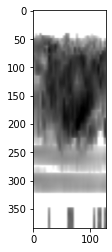

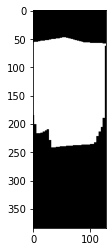

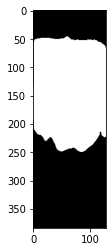

In [ ]:
x,y=train_gen. __getitem__(1)
predict=model.predict(x)
print(np.unique(y))
val=model.evaluate(x[2:3,:,:,:],y[2:3,:,:,:])
print(val)
plt.imshow(x[2,:,:,0],cmap='binary')
plt.show()

plt.imshow(y[2,:,:,0],cmap='binary_r')
plt.show()
m=predict[2,:,:,0]
m=np.where(m>=0.5, 1, 0)
vmin=0
vmax=1
sc=matplotlib.colors.Normalize(vmin, vmax)
plt.imshow(m,cmap='binary_r',norm=sc)
plt.show()

In [ ]:
with open(json_label, "w") as outfile:
  json.dump(history.history, outfile)

FileNotFoundError: ignored

#### Save Weights.


In [ ]:
#root = '/content/drive/MyDrive/Elizabeth_PhD_Folder/Colab_Notebooks/Models/'
#model_label = 'UNET_'+str(optname) + '_LR' +str(lr)
#model.save(root+model_label)